<a id='top'> </a>

In [1]:
%load_ext watermark
%watermark -a 'Author: James Bourbeau' -u -d -v -p numpy,matplotlib,scipy,pandas,sklearn,mlxtend

Author: James Bourbeau 
last updated: 2017-12-08 

CPython 2.7.13
IPython 5.3.0

numpy 1.12.1
matplotlib 2.0.2
scipy 0.19.0
pandas 0.20.1
sklearn 0.19.0
mlxtend 0.7.0


# Cosmic-ray composition unfolded spectrum
### Table of contents
1. [Define analysis free parameters](#Define-analysis-free-parameters)
1. [Data preprocessing](#Data-preprocessing)
2. [Fitting random forest](#Fit-random-forest-and-run-10-fold-CV-validation)
3. [Fraction correctly identified](#Fraction-correctly-identified)
4. [Spectrum](#Spectrum)
5. [Unfolding](#Unfolding)

In [2]:
from __future__ import division, print_function
import os
from collections import defaultdict
import itertools
import numpy as np
from scipy import interp
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.animation import FuncAnimation
import seaborn.apionly as sns
import matplotlib as mpl
import pyprind

from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc, classification_report
from sklearn.model_selection import cross_val_score, StratifiedShuffleSplit, KFold, StratifiedKFold
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

import comptools as comp
import comptools.analysis.plotting as plotting
    
# color_dict allows for a consistent color-coding for each composition
color_dict = comp.analysis.get_color_dict()

%matplotlib inline

# Define analysis free parameters
[ [back to top](#top) ]

Whether or not to train on 'light' and 'heavy' composition classes, or the individual compositions

In [3]:
# config = 'IC79.2010'
config = 'IC86.2012'
num_groups = 4
comp_list = comp.get_comp_list(num_groups=num_groups)

In [4]:
comp_list

['PPlus', 'He4Nucleus', 'O16Nucleus', 'Fe56Nucleus']

Get composition classifier pipeline

Define energy binning for this analysis

In [5]:
energybins = comp.analysis.get_energybins(config)

In [6]:
log_energy_min = energybins.log_energy_min
log_energy_max = energybins.log_energy_max

# Data preprocessing
[ [back to top](#top) ]
1. Load simulation/data dataframe and apply specified quality cuts
2. Extract desired features from dataframe
3. Get separate testing and training datasets

In [7]:
df_sim_train, df_sim_test = comp.load_sim(config=config, log_energy_min=log_energy_min, log_energy_max=log_energy_max)
feature_list, feature_labels = comp.analysis.get_training_features()

In [8]:
feature_list

['lap_cos_zenith', 'log_s125', 'log_dEdX']

## Spectrum
[ [back to top](#top) ]

In [9]:
unfolding_dir  = os.path.join(comp.paths.comp_data_dir, config, 'unfolding')

In [10]:
# Solid angle
theta_max = 40 if config == 'IC79.2010' else 65
# solid_angle = 2*np.pi*(np.cos(df_sim_train['lap_zenith'].min())-np.cos(df_sim_train['lap_zenith'].max()))
solid_angle = np.pi*np.sin(np.deg2rad(theta_max))**2
solid_angle

2.5804847429997841

In [11]:
livetime, livetime_err = comp.get_detector_livetime(config=config)
livetime, livetime_err

(28442248.921, 2699.1328177300002)

In [12]:
# Get simulation thrown areas for each energy bin
thrown_radii = comp.simfunctions.get_sim_thrown_radius(energybins.log_energy_midpoints)
thrown_areas = np.pi * thrown_radii**2
thrown_area = thrown_areas.max()
print('thrown_area = {}'.format(thrown_area))

thrown_area = 9079202.76887


In [13]:
geom_factor = (np.cos(np.deg2rad(theta_max)) + df_sim_train.lap_cos_zenith.min()) / 2
geom_factor

0.61574757849372552

## Plot unfolded flux at each iteration

In [14]:
model_name = 'Jeffreys'
# model_name = 'H3a'
# model_name = 'Polygonato'

In [15]:
df_file = os.path.join(unfolding_dir,
                       'pyunfold_output_{}-groups.hdf'.format(num_groups))
df_unfolding = pd.read_hdf(df_file, model_name, mode='r')

In [16]:
df_unfolding

,sys_err,stat_err,n_c
0,"[29725681.9336, 9398941.76991, 6751560.61289, ...","[133230.785461, 45771.0071206, 34368.3736111, ...","[249880539.368, 90749471.8705, 60383710.9292, ..."
1,"[34440351.189, 11076698.8346, 9415171.99495, 9...","[142956.483928, 49602.0543431, 46870.5806738, ...","[219682689.769, 84788523.5198, 61533415.2617, ..."
2,"[37757804.213, 12688182.6878, 11889178.3493, 1...","[159929.926021, 54796.0451625, 57926.9871271, ...","[202883841.057, 81888676.8064, 63902997.7771, ..."
3,"[40149643.9061, 14201929.0165, 14080510.9238, ...","[173624.925024, 59984.4921324, 67715.6292119, ...","[191745403.039, 80000168.5641, 66339790.6183, ..."
4,"[41865479.2627, 15597812.5114, 16005683.4048, ...","[185442.71235, 65396.7990601, 76169.1522515, 1...","[183679614.817, 78516773.5992, 68517298.2798, ..."
5,"[43100878.4667, 16880405.161, 17717033.6726, 2...","[195650.417299, 70929.6908381, 83312.8421814, ...","[177588634.913, 77237147.8115, 70364242.7894, ..."


/home/jbourbeau/.virtualenvs/composition/lib/python2.7/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


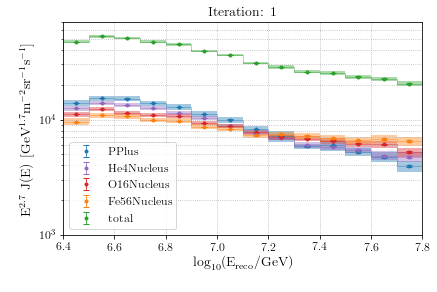

In [17]:
fig, ax = plt.subplots()

def update(i):
    ax.clear()
    idx_iter, df_iter = i
    color_dict_iter = {}
    color_dict_iter['light'] = sns.color_palette('Blues', len(df_unfolding.index)).as_hex()[idx_iter]
    color_dict_iter['heavy'] = sns.color_palette('Oranges', len(df_unfolding.index)).as_hex()[idx_iter]
    color_dict_iter['total'] = sns.color_palette('Greens', len(df_unfolding.index)).as_hex()[idx_iter]

    counts, counts_sys_err, counts_stat_err = {}, {}, {}
    for idx, composition in enumerate(comp_list):
        counts[composition] = df_iter['n_c'][idx::num_groups]
        counts_sys_err[composition] = df_iter['sys_err'][idx::num_groups]
        counts_stat_err[composition] = df_iter['stat_err'][idx::num_groups]
        
    for idx, composition in enumerate(comp_list):
        if idx == 0:
            counts['total'] = np.zeros_like(counts[composition])
            counts_sys_err['total'] = np.zeros_like(counts[composition])
            counts_stat_err['total'] = np.zeros_like(counts[composition])
        counts['total'] += counts[composition]
        counts_sys_err['total'] += counts_sys_err[composition]**2
        counts_stat_err['total'] += counts_stat_err[composition]**2
    counts_sys_err['total'] = np.sqrt(counts_sys_err['total'])
    counts_stat_err['total'] = np.sqrt(counts_stat_err['total'])    
    
    for composition in comp_list + ['total']:    
        flux, flux_err_sys = comp.analysis.get_flux(counts[composition], counts_sys_err[composition],
                                                     energybins=energybins.energy_bins,
                                                     eff_area=thrown_area,
                                                     livetime=livetime, livetime_err=livetime_err, 
                                                     solid_angle=solid_angle)
        flux, flux_err_stat = comp.analysis.get_flux(counts[composition], counts_stat_err[composition],
                                                     energybins=energybins.energy_bins,
                                                     eff_area=thrown_area,
                                                     livetime=livetime, livetime_err=livetime_err, 
                                                     solid_angle=solid_angle)
        
        plotting.plot_steps(energybins.log_energy_bins, flux, yerr=flux_err_sys,
                            ax=ax, alpha=0.4, fillalpha=0.4,  
                            color=color_dict[composition])
        ax.errorbar(energybins.log_energy_midpoints, flux, yerr=flux_err_stat,  
                    color=color_dict[composition], ls='None', marker='.', 
                    label=composition)
        

    ax.set_yscale("log", nonposy='clip')
    ax.set_xlabel('$\mathrm{\log_{10}(E_{reco}/GeV)}$')
    ax.set_ylabel('$\mathrm{ E^{2.7} \ J(E) \ [GeV^{1.7} m^{-2} sr^{-1} s^{-1}]}$')
    ax.set_title('Iteration: {}'.format(idx_iter+1))
    ax.set_xlim(6.4, 7.8)
    ax.set_ylim([1e3, 7e4])
    ax.grid(linestyle='dotted', which="both")
    ax.legend()
    
    return ax

anim = FuncAnimation(fig, update, frames=list(df_unfolding.iterrows()),
                     interval=1250)
iter_unfold_outfile = os.path.join(comp.paths.figures_dir, 'unfolding', config, 'iterations', 
                                   model_name, '{}-groups'.format(num_groups),
                                   'flux_iter_{}-prior.gif'.format(model_name))
comp.check_output_dir(iter_unfold_outfile)
anim.save(iter_unfold_outfile, dpi=300, writer='imagemagick')

In [32]:
# for idx_iter, df_iter in df_unfolding.iterrows():

#     fig, ax = plt.subplots()
#     color_dict_iter = {}
#     color_dict_iter['light'] = sns.color_palette('Blues', len(df_unfolding.index)).as_hex()[idx_iter]
#     color_dict_iter['heavy'] = sns.color_palette('Oranges', len(df_unfolding.index)).as_hex()[idx_iter]
#     color_dict_iter['total'] = sns.color_palette('Greens', len(df_unfolding.index)).as_hex()[idx_iter]

#     counts, counts_sys_err, counts_stat_err = {}, {}, {}
#     for idx, composition in enumerate(comp_list):
#         counts[composition] = df_iter['n_c'][idx::num_groups]
#         counts_sys_err[composition] = df_iter['sys_err'][idx::num_groups]
#         counts_stat_err[composition] = df_iter['stat_err'][idx::num_groups]
        
#     for idx, composition in enumerate(comp_list):
#         if idx == 0:
#             counts['total'] = np.zeros_like(counts[composition])
#             counts_sys_err['total'] = np.zeros_like(counts[composition])
#             counts_stat_err['total'] = np.zeros_like(counts[composition])
#         counts['total'] += counts[composition]
#         counts_sys_err['total'] += counts_sys_err[composition]**2
#         counts_stat_err['total'] += counts_stat_err[composition]**2
#     counts_sys_err['total'] = np.sqrt(counts_sys_err['total'])
#     counts_stat_err['total'] = np.sqrt(counts_stat_err['total'])
    
# #     counts['total'] = counts['light'] + counts['heavy']
# #     counts_sys_err['total'] = np.sqrt(counts_sys_err['light']**2 + counts_sys_err['heavy']**2)
# #     counts_stat_err['total'] = np.sqrt(counts_stat_err['light']**2 + counts_stat_err['heavy']**2)
    
    
#     for composition in comp_list + ['total']:    
#         flux, flux_err_sys = comp.analysis.get_flux(counts[composition], counts_sys_err[composition],
#                                                      energybins=energybins.energy_bins,
#                                                      eff_area=thrown_area,
#                                                      livetime=livetime, livetime_err=livetime_err, 
#                                                      solid_angle=solid_angle)
#         flux, flux_err_stat = comp.analysis.get_flux(counts[composition], counts_stat_err[composition],
#                                                      energybins=energybins.energy_bins,
#                                                      eff_area=thrown_area,
#                                                      livetime=livetime, livetime_err=livetime_err, 
#                                                      solid_angle=solid_angle)
        
#         plotting.plot_steps(energybins.log_energy_bins, flux, yerr=flux_err_sys,
#                             ax=ax, alpha=0.4, fillalpha=0.4,  
#                             color=color_dict[composition])
#         ax.errorbar(energybins.log_energy_midpoints, flux, yerr=flux_err_stat,  
#                     color=color_dict[composition], ls='None', marker='.', 
#                     label=composition)
        

#     ax.set_yscale("log", nonposy='clip')
#     ax.set_xlabel('$\mathrm{\log_{10}(E_{reco}/GeV)}$')
#     ax.set_ylabel('$\mathrm{ E^{2.7} \ J(E) \ [GeV^{1.7} m^{-2} sr^{-1} s^{-1}]}$')
#     ax.set_title('Iteration: {}'.format(idx_iter+1))
# #     stopping_cond_str = 'Stopping condition: KS p-val $< {}$'.format('0.{}'.format(ks_pval_str.split('p')[-1]))
# #     bbox_props = dict(boxstyle='round', ec='gray', lw=0.8, fc='white', alpha=0.5)
# #     ax.text(7.2, 7e4, stopping_cond_str, bbox=bbox_props)

#     ax.set_xlim(6.4, 7.8)
#     ax.set_ylim([1e3, 7e4])
#     ax.grid(linestyle='dotted', which="both")
#     ax.legend()
# #     ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), frameon=False)
#     iter_unfold_outfile = os.path.join(comp.paths.figures_dir, 'unfolding', config, 'iterations', 
#                                        model_name, '{}-groups'.format(num_groups),
#                                        'flux_iter_{}.png'.format(idx_iter))
#     comp.check_output_dir(iter_unfold_outfile)
#     plt.savefig(iter_unfold_outfile)
#     plt.show()

### Plot comparison of final unfolded flux for different priors

In [47]:
model_names = ['Jeffreys']
# model_names = ['Jeffreys', 'H3a']
# model_names = ['Jeffreys', 'h3a', 'Hoerandel5']

Load 3-year analysis flux

In [48]:
flux_data_3yr_array = np.load(os.path.join(comp.paths.comp_data_dir, 'fraction_spectrum_fit_data.npy'))

In [49]:
flux_data_3yr_format = ['log_energy_midpoints',
                        'PPlus_flux', 'PPlus_err_down', 'PPlus_err_up', 'PPlus_err_down2', 'PPlus_err_up2',
                        'He4Nucleus_flux', 'He4Nucleus_err_down', 'He4Nucleus_err_up', 'He4Nucleus_err_down2', 'He4Nucleus_err_up2',
                        'O16Nucleus_flux', 'O16Nucleus_err_down', 'O16Nucleus_err_up', 'O16Nucleus_err_down2', 'O16Nucleus_err_up2',
                        'Fe56Nucleus_flux', 'Fe56Nucleus_err_down', 'Fe56Nucleus_err_up', 'Fe56Nucleus_err_down2', 'Fe56Nucleus_err_up2']

In [50]:
flux_data_3yr = {key: value.astype(float) for key, value in zip(flux_data_3yr_format, flux_data_3yr_array)}
flux_comp_3yr = {}
MC_comp_list = ['PPlus', 'He4Nucleus', 'O16Nucleus', 'Fe56Nucleus']
for MC_comp in MC_comp_list:
    comp_group = comp.composition_encoding.composition_group_labels([MC_comp], num_groups=num_groups)[0]
    print(comp_group)
    if '{}_flux'.format(comp_group) not in flux_comp_3yr:
        flux_comp_3yr['{}_flux'.format(comp_group)] = flux_data_3yr['{}_flux'.format(MC_comp)]
        flux_comp_3yr['{}_err_down'.format(comp_group)] = flux_data_3yr['{}_err_down'.format(MC_comp)]**2
        flux_comp_3yr['{}_err_up'.format(comp_group)] = flux_data_3yr['{}_err_up'.format(MC_comp)]**2
    else:
        flux_comp_3yr['{}_flux'.format(comp_group)] += flux_data_3yr['{}_flux'.format(MC_comp)]
        flux_comp_3yr['{}_err_down'.format(comp_group)] += flux_data_3yr['{}_err_down'.format(MC_comp)]**2
        flux_comp_3yr['{}_err_up'.format(comp_group)] += flux_data_3yr['{}_err_up'.format(MC_comp)]**2

for composition in comp_list:
    flux_comp_3yr['{}_err_down'.format(composition)] = np.sqrt(flux_comp_3yr['{}_err_down'.format(composition)])
    flux_comp_3yr['{}_err_up'.format(composition)] = np.sqrt(flux_comp_3yr['{}_err_up'.format(composition)])

flux_comp_3yr['total_flux'] = np.sum((flux_comp_3yr['{}_flux'.format(composition)] for composition in comp_list),
                                     axis=0)
flux_comp_3yr['total_err_down'] = np.sqrt(np.sum((flux_comp_3yr['{}_err_down'.format(composition)]**2 for composition in comp_list),
                                     axis=0))
flux_comp_3yr['total_err_up'] = np.sqrt(np.sum((flux_comp_3yr['{}_err_up'.format(composition)]**2 for composition in comp_list),
                                     axis=0))


PPlus
He4Nucleus
O16Nucleus
Fe56Nucleus


In [55]:
plot_3yr = True

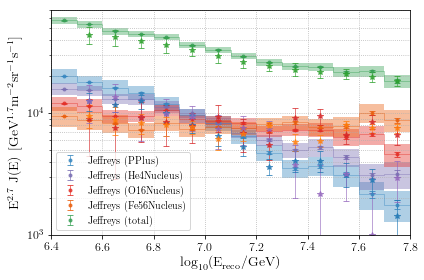

In [56]:
fig, ax = plt.subplots()
marker_dict = {model: marker for model, marker in zip(model_names, '.^*o')}
color_dict_model = {}
color_dict_model['light'] = sns.color_palette('Blues', len(model_names)+1).as_hex()[::-1]
color_dict_model['intermediate'] = sns.color_palette('Reds', len(model_names)+1).as_hex()[::-1]
color_dict_model['heavy'] = sns.color_palette('Oranges', len(model_names)+1).as_hex()[::-1]

color_dict_model['PPlus'] = sns.color_palette('Blues', len(model_names)+1).as_hex()[::-1]
color_dict_model['O16Nucleus'] = sns.color_palette('Reds', len(model_names)+1).as_hex()[::-1]
color_dict_model['He4Nucleus'] = sns.color_palette('Purples', len(model_names)+1).as_hex()[::-1]
color_dict_model['Fe56Nucleus'] = sns.color_palette('Oranges', len(model_names)+1).as_hex()[::-1]

color_dict_model['total'] = sns.color_palette('Greens', len(model_names)+1).as_hex()[::-1]
for idx_model, model_name in enumerate(model_names):
    
    df_file = os.path.join(unfolding_dir, 
                           'pyunfold_output_{}-groups.hdf'.format(num_groups))
    df_unfolding = pd.read_hdf(df_file, model_name, mode='r')
    df_final_iter = df_unfolding.iloc[-1]
    
    counts, counts_sys_err, counts_stat_err = {}, {}, {}
    for idx, composition in enumerate(comp_list):
        counts[composition] = df_final_iter['n_c'][idx::num_groups]
        counts_sys_err[composition] = df_final_iter['sys_err'][idx::num_groups]
        counts_stat_err[composition] = df_final_iter['stat_err'][idx::num_groups]
        
    for idx, composition in enumerate(comp_list):
        if idx == 0:
            counts['total'] = np.zeros_like(counts[composition])
            counts_sys_err['total'] = np.zeros_like(counts[composition])
            counts_stat_err['total'] = np.zeros_like(counts[composition])
        counts['total'] += counts[composition]
        counts_sys_err['total'] += counts_sys_err[composition]**2
        counts_stat_err['total'] += counts_stat_err[composition]**2
    counts_sys_err['total'] = np.sqrt(counts_sys_err['total'])
    counts_stat_err['total'] = np.sqrt(counts_stat_err['total'])
    
    for composition in comp_list + ['total']:    
        flux, flux_err_sys = comp.analysis.get_flux(counts[composition], counts_sys_err[composition],
                                                     energybins=energybins.energy_bins,
                                                     eff_area=thrown_area,
#                                                      eff_area=thrown_area*geom_factor,
                                                     livetime=livetime, livetime_err=livetime_err, 
                                                     solid_angle=solid_angle)
        flux, flux_err_stat = comp.analysis.get_flux(counts[composition], counts_stat_err[composition],
                                                     energybins=energybins.energy_bins,
                                                     eff_area=thrown_area,
#                                                      eff_area=thrown_area*geom_factor, 
                                                     livetime=livetime, livetime_err=livetime_err, 
                                                     solid_angle=solid_angle)
        
        plotting.plot_steps(energybins.log_energy_bins, flux, yerr=flux_err_sys,
                            ax=ax, alpha=0.4, fillalpha=0.4,  
                            color=color_dict_model[composition][idx_model])

        ax.errorbar(energybins.log_energy_midpoints, flux, yerr=flux_err_stat,  
                    color=color_dict_model[composition][idx_model], ls='None', marker=marker_dict[model_name], 
                    label=model_name + ' ({})'.format(composition), alpha=0.8)


# Add 3-year composition analysis flux for comparison 
if plot_3yr:
    for composition in comp_list + ['total']:
        ax.errorbar(flux_data_3yr['log_energy_midpoints'], 
                    flux_comp_3yr['{}_flux'.format(composition)],
                    yerr=[flux_comp_3yr['{}_err_down'.format(composition)],
                          flux_comp_3yr['{}_err_up'.format(composition)]],  
                    ls='None', marker='*', color=color_dict[composition],
    #                 label='3-year ({})'.format(composition),
                    alpha=0.75)
    
    
ax.set_yscale("log", nonposy='clip')
ax.set_xlabel('$\mathrm{\log_{10}(E_{reco}/GeV)}$')
ax.set_ylabel('$\mathrm{ E^{2.7} \ J(E) \ [GeV^{1.7} m^{-2} sr^{-1} s^{-1}]}$')

# ax.set_xlim(6.4, 9.0)
ax.set_xlim(6.4, 7.8)
ax.set_ylim([1e3, 7e4])

ax.grid(linestyle='dotted', which="both")
ax.legend(loc='lower left', ncol=len(model_names), fontsize=10)
# leg = plt.legend(loc='upper center', frameon=False,
#           bbox_to_anchor=(0.5,  # horizontal
#                           1.15),# vertical 
#           ncol=len(comp_list)+1, fancybox=False)

if plot_3yr:
    flux_outfile = os.path.join(comp.paths.figures_dir, 'unfolding', config, 
                                'flux_{}-groups-3yr-comparison.png'.format(num_groups))
else:
    flux_outfile = os.path.join(comp.paths.figures_dir, 'unfolding', config, 
                                'flux_{}-groups.png'.format(num_groups))
comp.check_output_dir(flux_outfile)
plt.savefig(flux_outfile)
plt.show()

In [57]:
model_flux = comp.analysis.spectrumfunctions.get_model_flux('H3a', energy=energybins.energy_midpoints,
                                                            num_groups=num_groups)
model_flux.head()

,flux_PPlus,flux_He4Nucleus,flux_O16Nucleus,flux_Fe56Nucleus,flux_total
0,2.776881e-13,4.410539e-13,2.431070e-13,1.651639e-13,1.127013e-12
1,1.400420e-13,2.342681e-13,1.326787e-13,9.061387e-14,5.976026e-13
2,6.938239e-14,1.231602e-13,7.229419e-14,4.969588e-14,3.145327e-13
3,3.365669e-14,6.392754e-14,3.930950e-14,2.724088e-14,1.641346e-13
4,1.593250e-14,3.266399e-14,2.131730e-14,1.492133e-14,8.483512e-14


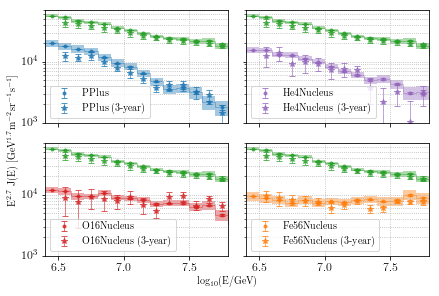

In [58]:
if num_groups == 4:
    fig, axarr = plt.subplots(2, 2, sharex=True, sharey=True)
#     model_name = 'H3a'
    model_name = 'Jeffreys'
    df_file = os.path.join(unfolding_dir, 
                           'pyunfold_output_{}-groups.hdf'.format(num_groups))
    df_unfolding = pd.read_hdf(df_file, model_name, mode='r')
#     print(df_unfolding)
    df_final_iter = df_unfolding.iloc[-1]

    counts, counts_sys_err, counts_stat_err = {}, {}, {}
    for idx, composition in enumerate(comp_list):
        counts[composition] = df_final_iter['n_c'][idx::num_groups]
        counts_sys_err[composition] = df_final_iter['sys_err'][idx::num_groups]
        counts_stat_err[composition] = df_final_iter['stat_err'][idx::num_groups]

    for idx, composition in enumerate(comp_list):
        if idx == 0:
            counts['total'] = np.zeros_like(counts[composition])
            counts_sys_err['total'] = np.zeros_like(counts[composition])
            counts_stat_err['total'] = np.zeros_like(counts[composition])
        counts['total'] += counts[composition]
        counts_sys_err['total'] += counts_sys_err[composition]**2
        counts_stat_err['total'] += counts_stat_err[composition]**2
    counts_sys_err['total'] = np.sqrt(counts_sys_err['total'])
    counts_stat_err['total'] = np.sqrt(counts_stat_err['total'])


    flux_total, flux_total_err_sys = comp.analysis.get_flux(counts['total'], counts_sys_err['total'],
                                                     energybins=energybins.energy_bins,
                                                     eff_area=thrown_area,
                                                     livetime=livetime, livetime_err=livetime_err, 
                                                     solid_angle=solid_angle)
    flux_total, flux_total_err_stat = comp.analysis.get_flux(counts['total'], counts_stat_err['total'],
                                                 energybins=energybins.energy_bins,
                                                 eff_area=thrown_area,
                                                 livetime=livetime, livetime_err=livetime_err, 
                                                 solid_angle=solid_angle)


    for composition, ax in zip(comp_list, axarr.flatten()):

        flux, flux_err_sys = comp.analysis.get_flux(counts[composition], counts_sys_err[composition],
                                                     energybins=energybins.energy_bins,
                                                     eff_area=thrown_area,
                                                     livetime=livetime, livetime_err=livetime_err, 
                                                     solid_angle=solid_angle)
        flux, flux_err_stat = comp.analysis.get_flux(counts[composition], counts_stat_err[composition],
                                                     energybins=energybins.energy_bins,
                                                     eff_area=thrown_area,
                                                     livetime=livetime, livetime_err=livetime_err, 
                                                     solid_angle=solid_angle)

        plotting.plot_steps(energybins.log_energy_bins, flux, yerr=flux_err_sys,
                            ax=ax, alpha=0.4, fillalpha=0.4,  
                            color=color_dict[composition])

        ax.errorbar(energybins.log_energy_midpoints, flux, yerr=flux_err_stat,  
                    color=color_dict[composition], ls='None', marker='.', 
                    label=composition, alpha=0.8)
        
        # Plot total flux
        plotting.plot_steps(energybins.log_energy_bins, flux_total, yerr=flux_total_err_sys,
                            ax=ax, alpha=0.4, fillalpha=0.4,  
                            color=color_dict['total'])

        ax.errorbar(energybins.log_energy_midpoints, flux_total, yerr=flux_total_err_stat,  
                    color=color_dict['total'], ls='None', marker='.', 
#                     label='total',
                    alpha=0.8)



    # Add 3-year composition analysis flux for comparison 
        if plot_3yr:
            ax.errorbar(flux_data_3yr['log_energy_midpoints'], 
                        flux_comp_3yr['{}_flux'.format(composition)],
                        yerr=[flux_comp_3yr['{}_err_down'.format(composition)],
                              flux_comp_3yr['{}_err_up'.format(composition)]],  
                        ls='None', marker='*', color=color_dict[composition],
                        label='{} (3-year)'.format(composition),
                        alpha=0.75)
            ax.errorbar(flux_data_3yr['log_energy_midpoints'], 
                        flux_comp_3yr['total_flux'],
                        yerr=[flux_comp_3yr['total_err_down'],
                              flux_comp_3yr['total_err_up']],  
                        ls='None', marker='*', color=color_dict['total'],
                        alpha=0.75)


        ax.set_yscale("log", nonposy='clip')
        ax.set_xlim(6.4, 7.8)
        ax.set_ylim([1e3, 7e4])

        ax.grid(linestyle='dotted', which="both")
        ax.legend(loc='lower left', ncol=1, fontsize=10)
        
    fig.text(0.5, -0.01, '$\mathrm{\log_{10}(E/GeV)}$', ha='center')
    fig.text(-0.01, 0.5, '$\mathrm{ E^{2.7} \ J(E) \ [GeV^{1.7} m^{-2} sr^{-1} s^{-1}]}$',
             va='center', rotation='vertical')
    
    flux_outfile = os.path.join(comp.paths.figures_dir, 'unfolding', config, 
                                'flux_grid_{}-groups.png'.format(num_groups))
    comp.check_output_dir(flux_outfile)
    plt.savefig(flux_outfile, dpi=1000)
    plt.show()

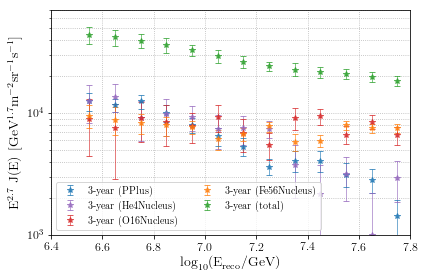

In [30]:
fig, ax = plt.subplots()
# Add 3-year composition analysis flux for comparison 
for composition in comp_list + ['total']:
    ax.errorbar(flux_data_3yr['log_energy_midpoints'], 
                flux_comp_3yr['{}_flux'.format(composition)],
                yerr=[flux_comp_3yr['{}_err_down'.format(composition)],
                      flux_comp_3yr['{}_err_up'.format(composition)]],  
                ls='None', marker='*', color=color_dict[composition],
                label='3-year ({})'.format(composition),
                alpha=0.75)
    
ax.set_yscale("log", nonposy='clip')
ax.set_xlabel('$\mathrm{\log_{10}(E_{reco}/GeV)}$')
ax.set_ylabel('$\mathrm{ E^{2.7} \ J(E) \ [GeV^{1.7} m^{-2} sr^{-1} s^{-1}]}$')

# ax.set_xlim(6.4, 9.0)
ax.set_xlim(6.4, 7.8)
ax.set_ylim([1e3, 7e4])

ax.grid(linestyle='dotted', which="both")
ax.legend(loc='lower left', ncol=2, fontsize=10)
# ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), frameon=False)cd 

# leg = plt.legend(loc='upper center', frameon=False,
#           bbox_to_anchor=(0.5,  # horizontal
#                           1.15),# vertical 
#           ncol=len(comp_list)+1, fancybox=False)
flux_3yr_outfile = os.path.join(comp.paths.figures_dir, 'unfolding', config, 
                                'flux_3yr-analysis_{}-groups.png'.format(num_groups))
comp.check_output_dir(flux_3yr_outfile)
plt.savefig(flux_3yr_outfile)
plt.show()